<a href="https://colab.research.google.com/github/tylerlum/deep_learning_monte_carlo_dropout/blob/main/mc_dropout_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Monte Carlo Dropout on MNIST

Reference:
https://www.depends-on-the-definition.com/model-uncertainty-in-deep-learning-with-monte-carlo-dropout/#2-selection-by-variance

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Flatten, SpatialDropout2D, SpatialDropout1D, AlphaDropout
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [2]:
batch_size = 128
num_classes = 10
epochs = 20

# input image dimensions
img_rows, img_cols = 28, 28

In [3]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [6]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [7]:
def get_dropout(input_tensor, p=0.5, mc=False):
    if mc:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor)


def get_model(mc=False, act="relu"):
    inp = Input(input_shape)
    x = Conv2D(32, kernel_size=(3, 3), activation=act)(inp)
    x = Conv2D(64, kernel_size=(3, 3), activation=act)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = get_dropout(x, p=0.25, mc=mc)
    x = Flatten()(x)
    x = Dense(128, activation=act)(x)
    x = get_dropout(x, p=0.5, mc=mc)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [8]:
model = get_model(mc=False, act="relu")
mc_model = get_model(mc=True, act="relu")

In [9]:
h = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))

Epoch 1/20
469/469 [==============================] - 5s 10ms/step - loss: 2.2945 - accuracy: 0.1212 - val_loss: 2.2813 - val_accuracy: 0.2088
Epoch 2/20
469/469 [==============================] - 5s 10ms/step - loss: 2.2728 - accuracy: 0.1787 - val_loss: 2.2562 - val_accuracy: 0.3575
Epoch 3/20
469/469 [==============================] - 5s 10ms/step - loss: 2.2476 - accuracy: 0.2490 - val_loss: 2.2255 - val_accuracy: 0.4668
Epoch 4/20
469/469 [==============================] - 5s 10ms/step - loss: 2.2145 - accuracy: 0.3226 - val_loss: 2.1855 - val_accuracy: 0.5592
Epoch 5/20
469/469 [==============================] - 5s 10ms/step - loss: 2.1713 - accuracy: 0.3868 - val_loss: 2.1313 - val_accuracy: 0.6402
Epoch 6/20
469/469 [==============================] - 5s 10ms/step - loss: 2.1130 - accuracy: 0.4543 - val_loss: 2.0570 - val_accuracy: 0.6971
Epoch 7/20
469/469 [==============================] - 5s 10ms/step - loss: 2.0324 - accuracy: 0.5091 - val_loss: 1.9550 - val_accuracy: 0.7270

In [10]:
def plot_train_validation(history, plot_type):
  plt.plot(h.history[plot_type])
  plt.plot(h.history[f'val_{plot_type}'])
  plt.title(f'model {plot_type}')
  plt.ylabel(plot_type)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

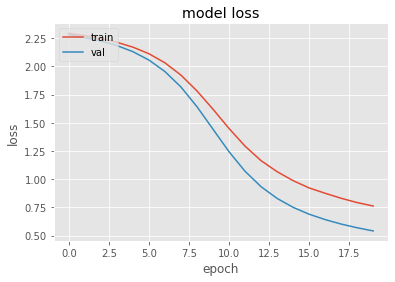

In [11]:
plot_train_validation(h, "loss")

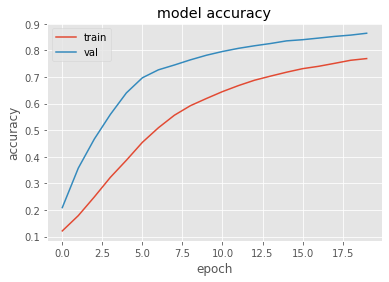

In [12]:
plot_train_validation(h, "accuracy")

In [13]:
# score of the normal model
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5414754152297974
Test accuracy: 0.8646000027656555


In [14]:
h_mc = mc_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/20
469/469 [==============================] - 5s 10ms/step - loss: 2.2885 - accuracy: 0.1316 - val_loss: 2.2679 - val_accuracy: 0.1846
Epoch 2/20
469/469 [==============================] - 5s 10ms/step - loss: 2.2461 - accuracy: 0.2357 - val_loss: 2.2193 - val_accuracy: 0.2935
Epoch 3/20
469/469 [==============================] - 5s 10ms/step - loss: 2.1925 - accuracy: 0.3269 - val_loss: 2.1577 - val_accuracy: 0.3679
Epoch 4/20
469/469 [==============================] - 5s 10ms/step - loss: 2.1205 - accuracy: 0.4003 - val_loss: 2.0728 - val_accuracy: 0.4312
Epoch 5/20
469/469 [==============================] - 5s 10ms/step - loss: 2.0227 - accuracy: 0.4651 - val_loss: 1.9578 - val_accuracy: 0.4948
Epoch 6/20
469/469 [==============================] - 5s 10ms/step - loss: 1.8956 - accuracy: 0.5176 - val_loss: 1.8141 - val_accuracy: 0.5478
Epoch 7/20
469/469 [==============================] - 5s 10ms/step - loss: 1.7408 - accuracy: 0.5685 - val_loss: 1.6442 - val_accuracy: 0.6056

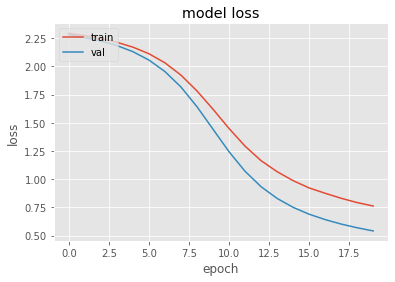

In [15]:
plot_train_validation(h_mc, "loss")

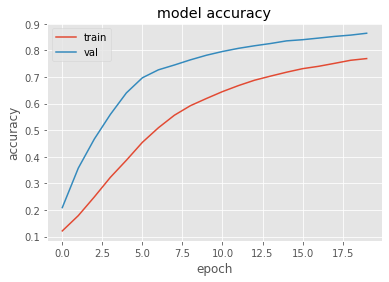

In [16]:
plot_train_validation(h_mc, "accuracy")

In [17]:
import tqdm

mc_predictions = []
for i in tqdm.tqdm(range(500)):
    y_p = mc_model.predict(x_test, batch_size=1000)
    mc_predictions.append(y_p)

100%|██████████| 500/500 [01:28<00:00,  5.65it/s]


In [18]:
# score of the mc model
accs = []
for y_p in mc_predictions:
    acc = accuracy_score(y_test.argmax(axis=1), y_p.argmax(axis=1))
    accs.append(acc)
print("MC accuracy: {:.1%}".format(sum(accs)/len(accs)))

MC accuracy: 79.4%


In [19]:
mc_ensemble_pred = np.array(mc_predictions).mean(axis=0).argmax(axis=1)
ensemble_acc = accuracy_score(y_test.argmax(axis=1), mc_ensemble_pred)
print("MC-ensemble accuracy: {:.1%}".format(ensemble_acc))

MC-ensemble accuracy: 87.2%


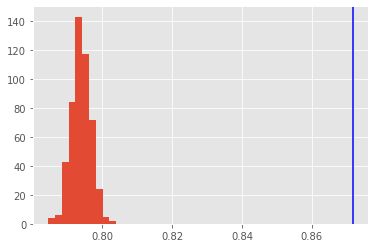

In [20]:
plt.hist(accs)
plt.axvline(x=ensemble_acc, color="b")

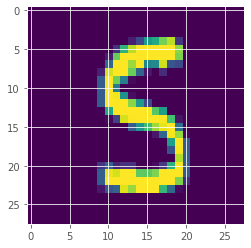

In [37]:
idx = 240
plt.imshow(x_test[idx][:,:,0])

In [38]:
p0 = np.array([p[idx] for p in mc_predictions])
print("posterior mean: {}".format(p0.mean(axis=0).argmax()))
print("true label: {}".format(y_test[idx].argmax()))
print()
# probability + variance
for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
    print("class: {}; proba: {:.1%}; var: {:.2%} ".format(i, prob, var))

posterior mean: 5
true label: 5

class: 0; proba: 2.3%; var: 3.87% 
class: 1; proba: 0.7%; var: 1.29% 
class: 2; proba: 1.0%; var: 1.73% 
class: 3; proba: 25.2%; var: 16.42% 
class: 4; proba: 0.3%; var: 0.39% 
class: 5; proba: 47.4%; var: 20.34% 
class: 6; proba: 3.0%; var: 3.37% 
class: 7; proba: 0.3%; var: 0.56% 
class: 8; proba: 18.9%; var: 15.09% 
class: 9; proba: 1.1%; var: 1.94% 


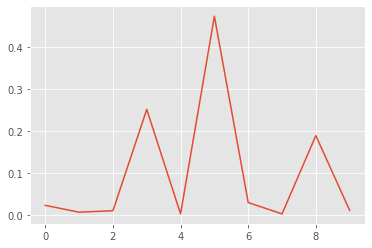

In [39]:
x, y = list(range(len(p0.mean(axis=0)))), p0.mean(axis=0)
plt.plot(x, y)

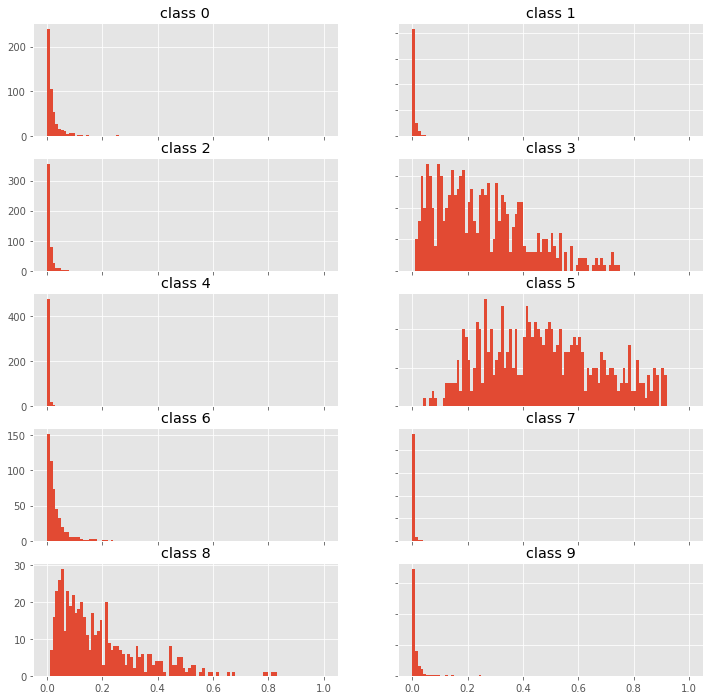

In [40]:
fig, axes = plt.subplots(5, 2, figsize=(12,12))

for i, ax in enumerate(fig.get_axes()):
    ax.hist(p0[:,i], bins=100, range=(0,1))
    ax.set_title(f"class {i}")
    ax.label_outer()

In [41]:
max_means = []
preds = []
for idx in range(len(mc_predictions)):
    px = np.array([p[idx] for p in mc_predictions])
    preds.append(px.mean(axis=0).argmax())
    max_means.append(px.mean(axis=0).max())

In [42]:
(np.array(max_means)).argsort()[:10]

array([483, 195,  96, 149, 191, 478, 175, 167,  92, 346])

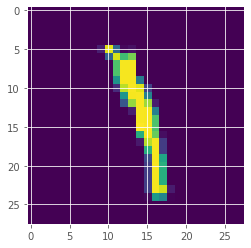

In [47]:
plt.imshow(x_test[96][:,:,0])

In [28]:
max_vars = []
for idx in range(len(mc_predictions)):
    px = np.array([p[idx] for p in mc_predictions])
    max_vars.append(px.std(axis=0)[px.mean(axis=0).argmax()])

In [29]:
(-np.array(max_vars)).argsort()[:10]

array([200, 222, 186, 291, 412, 406, 172,  48, 277, 126])

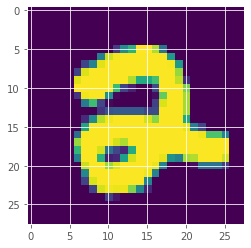

In [45]:
plt.imshow(x_test[222][:,:,0])

In [48]:
random_img = np.random.random(input_shape)

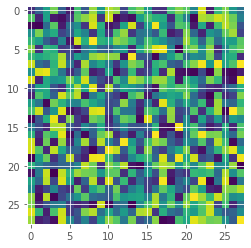

In [49]:
plt.imshow(random_img[:,:,0]);

In [50]:
random_predictions = []
for i in tqdm.tqdm(range(500)):
    y_p = mc_model.predict(np.array([random_img]))
    random_predictions.append(y_p)

100%|██████████| 500/500 [00:15<00:00, 32.07it/s]


In [51]:
p0 = np.array([p[0] for p in random_predictions])
print("posterior mean: {}".format(p0.mean(axis=0).argmax()))
print()
# probability + variance
for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
    print("class: {}; proba: {:.1%}; var: {:.2%} ".format(i, prob, var))

posterior mean: 2

class: 0; proba: 6.7%; var: 11.19% 
class: 1; proba: 0.1%; var: 0.15% 
class: 2; proba: 58.4%; var: 28.07% 
class: 3; proba: 17.8%; var: 18.80% 
class: 4; proba: 0.2%; var: 0.48% 
class: 5; proba: 12.3%; var: 16.17% 
class: 6; proba: 1.3%; var: 3.09% 
class: 7; proba: 0.3%; var: 0.87% 
class: 8; proba: 2.7%; var: 5.18% 
class: 9; proba: 0.1%; var: 0.23% 


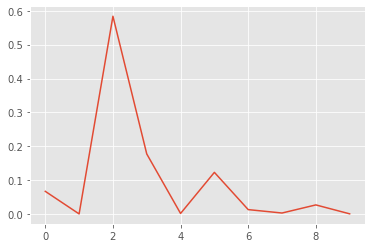

In [52]:
x, y = list(range(len(p0.mean(axis=0)))), p0.mean(axis=0)
plt.plot(x, y)

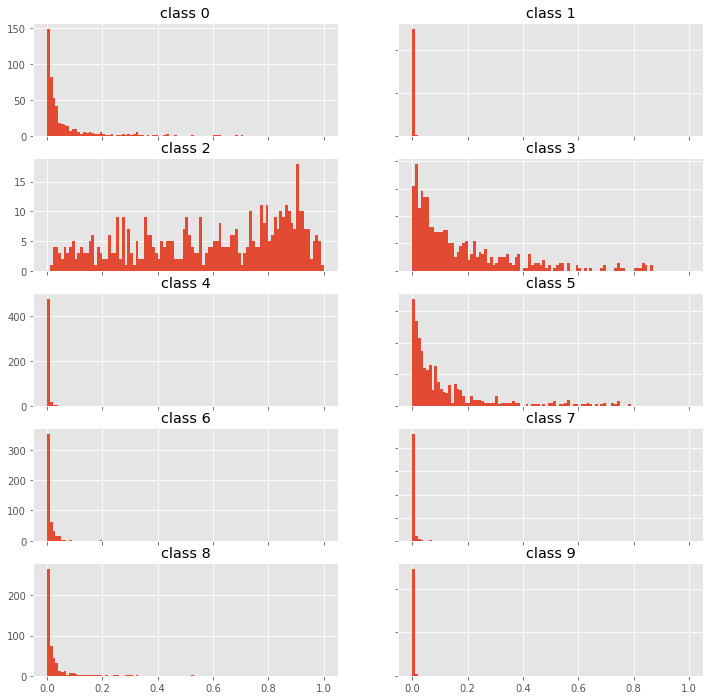

In [53]:
fig, axes = plt.subplots(5, 2, figsize=(12,12))

for i, ax in enumerate(fig.get_axes()):
    ax.hist(p0[:,i], bins=100, range=(0,1))
    ax.set_title(f"class {i}")
    ax.label_outer()

## Test out non-MC model and test if it can be converted to MC

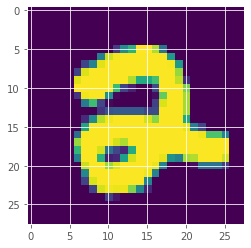

In [54]:
plt.imshow(x_test[222][:,:,0])

In [64]:
model.predict(np.expand_dims(x_test[222], axis=0), batch_size=1).argmax()

2

In [79]:
mc_model.predict(np.expand_dims(x_test[222], axis=0), batch_size=1).argmax()

6

In [65]:
from keras.models import clone_model
model2 = clone_model(model)
model2.set_weights(model.get_weights())
model2.predict(np.expand_dims(x_test[222], axis=0), batch_size=1).argmax()

2

In [82]:
layers = [l for l in model.layers]
x = layers[0].output
for i in range(1, len(layers)):
    if isinstance(layers[i], Dropout):
        x = Dropout(layers[i].rate)(x, training=True)
    else:
        x = layers[i](x)
        
model3 = Model(inputs=layers[0].input, outputs=x)
model3.set_weights(model.get_weights())
model3.predict(np.expand_dims(x_test[222], axis=0), batch_size=1).argmax()

2

In [91]:
model3.predict(np.expand_dims(x_test[222], axis=0), batch_size=1).argmax()

0

In [92]:
import tqdm

mc_predictions = []
for i in tqdm.tqdm(range(500)):
    y_p = model3.predict(x_test, batch_size=1000)
    mc_predictions.append(y_p)

100%|██████████| 500/500 [01:28<00:00,  5.66it/s]


In [93]:
# score of the mc model
accs = []
for y_p in mc_predictions:
    acc = accuracy_score(y_test.argmax(axis=1), y_p.argmax(axis=1))
    accs.append(acc)
print("MC accuracy: {:.1%}".format(sum(accs)/len(accs)))

MC accuracy: 78.2%


In [94]:
mc_ensemble_pred = np.array(mc_predictions).mean(axis=0).argmax(axis=1)
ensemble_acc = accuracy_score(y_test.argmax(axis=1), mc_ensemble_pred)
print("MC-ensemble accuracy: {:.1%}".format(ensemble_acc))

MC-ensemble accuracy: 86.3%
